# Project: Road Accidents in France based on Annual Road Traffic Accident Injury Database (2005 - 2023)

## Step 1: Exploration + Data Visualization

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Set styles
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (6, 4)

First, import the clean and reviewd data file

In [4]:
file_path = "../data/processed/accidents_processed.csv"
df = pd.read_csv(file_path, low_memory=False)

## 1. Distribution of accident severity (grav)
As our goal is to predict the severity of road accidents, I examined the distribution of the grav variable, which represents the severity level for each user involved. The majority of entries fall under "Light injury" and "Unharmed", while "Killed" and "Hospitalized" are significantly less frequent. This imbalance indicates a class imbalance problem, which will need to be addressed during model training using techniques such as resampling or weighted loss functions.

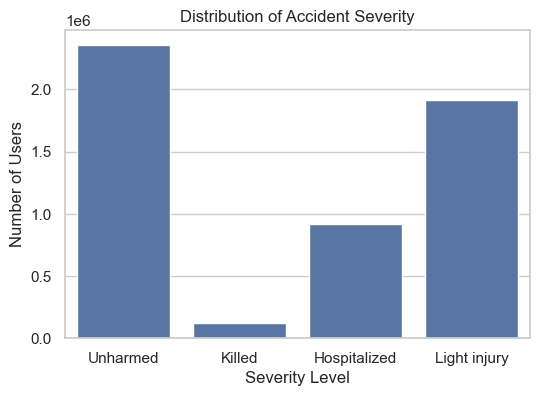

In [59]:
severity_labels = {
    1: "Unharmed", 2: "Killed", 3: "Hospitalized", 4: "Light injury"
}
df["grav_label"] = df["grav"].map(severity_labels)

sns.countplot(data=df, x="grav_label", order=severity_labels.values())
plt.title("Distribution of Accident Severity")
plt.xlabel("Severity Level")
plt.ylabel("Number of Users")
plt.show()

Check imbalance rate

In [63]:
df["grav"].value_counts(normalize=True).mul(100).round(2).astype(str) + " %"

grav
 1    44.41 %
 4    36.04 %
 3    17.29 %
 2     2.25 %
-1     0.02 %
Name: proportion, dtype: object

## 2. Accidents by Hour of Day

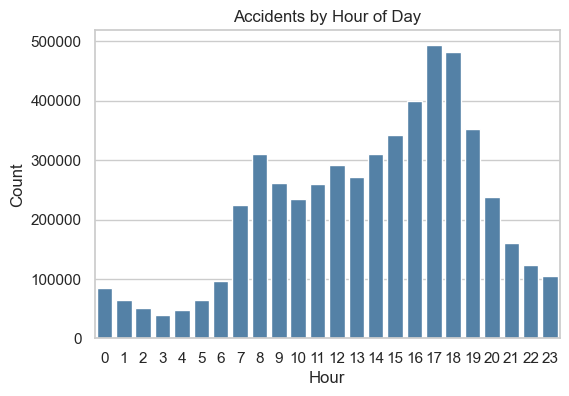

In [66]:
sns.countplot(data=df, x="hour", color="steelblue")
plt.title("Accidents by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

There is a strong increase in accident frequency between 7 AM and 7 PM, peaking around 5–6 PM, which corresponds to typical evening rush hour traffic. Morning (6–9 AM) and especially evening peaks (4–7 PM) reflect commuting patterns. Fewest accidents happen overnight (1–5 AM)—likely due to reduced traffic volume.

The accident frequency is not uniformly distributed across hours and time of day significantly impacts accident rates.

In [72]:
from scipy.stats import chisquare

hour_counts = df["hour"].value_counts().sort_index()
stat, p = chisquare(hour_counts)

print(f"Chi-squared statistic: {stat:.2f}, p-value: {p:.4f}")

Chi-squared statistic: 1970585.63, p-value: 0.0000


## 3. Accidents by weekday

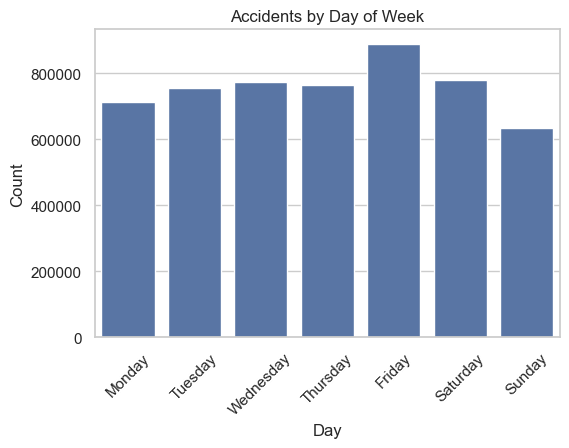

In [76]:
sns.countplot(data=df, x="weekday_name", order=[
    "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"
])
plt.title("Accidents by Day of Week")
plt.xlabel("Day")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

Weekdays see more accidents than weekends, especially Friday. May relate to commuting and traffic volume. There is not equal accident distribution across weekdays.

In [81]:
weekday_counts = df["weekday_name"].value_counts().sort_index()

stat, p = chisquare(weekday_counts)

print("Chi-squared statistic:", round(stat, 2))
print("p-value:", round(p, 4))

Chi-squared statistic: 46411.24
p-value: 0.0


## 4. Accident Severity by Sex

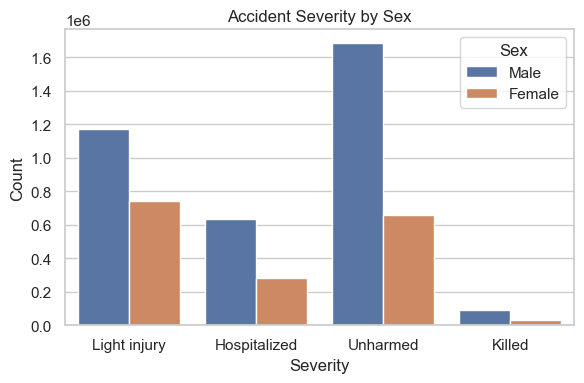

In [89]:
df_plot = df[df["sexe"].isin([1, 2])].copy()
df_plot["sexe_label"] = df_plot["sexe"].map({1: "Male", 2: "Female"})

# Plot
sns.countplot(data=df_plot, x="grav_label", hue="sexe_label")
plt.title("Accident Severity by Sex")
plt.xlabel("Severity")
plt.ylabel("Count")
plt.legend(title="Sex")
plt.tight_layout()
plt.show()

Across all severity levels, males are involved in more accidents than females. The difference is especially noticeable in the "Unharmed" category. Notably, the number of males who were killed is also higher than females, albeit overall fatalities are low compared to other categories.

This may reflect behavioral or exposure differences, for example, men may drive more often or under riskier conditions (e.g., at night, higher speed), contributing to higher accident counts.

Statistically (Chi-square test of independence), accident severity is independent of sex

In [91]:
from scipy.stats import chi2_contingency

contingency = pd.crosstab(df_plot["grav_label"], df_plot["sexe_label"])
chi2, p, _, _ = chi2_contingency(contingency)

print(f"Chi-square statistic: {chi2:.2f}, p-value: {p:.4f}")

Chi-square statistic: 60534.70, p-value: 0.0000


## 5. Severity by Urban vs. Rural Area (agg)

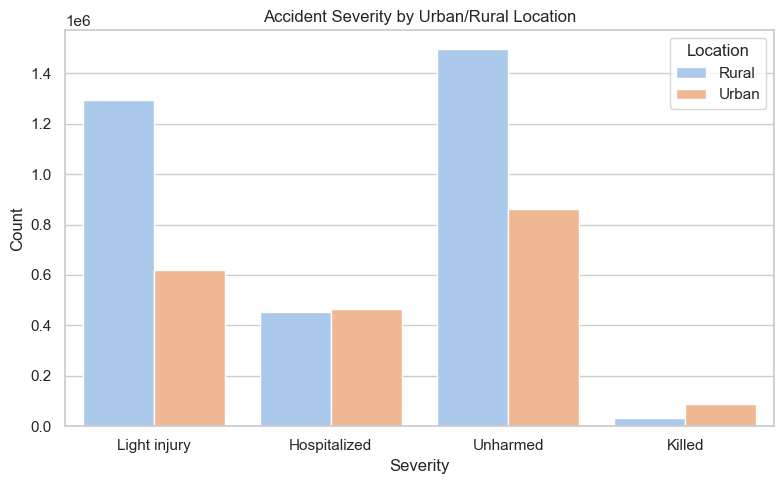

In [99]:
df_plot = df[df["agg"].isin([1, 2])].copy()
df_plot["agg_label"] = df_plot["agg"].map({1: "Urban", 2: "Rural"})
df_plot["grav_label"] = df_plot["grav"].map({
    1: "Unharmed", 
    2: "Killed", 
    3: "Hospitalized", 
    4: "Light injury"
})

# Plot
plt.figure(figsize=(8, 5))
sns.countplot(data=df_plot, x="grav_label", hue="agg_label", palette="pastel")
plt.title("Accident Severity by Urban/Rural Location")
plt.xlabel("Severity")
plt.ylabel("Count")
plt.legend(title="Location")
plt.tight_layout()
plt.show()

Rural areas see more 'Light injury' and 'Unharmed' cases, possibly due to higher speeds but lower traffic density. Urban areas have slightly more fatalities, although overall fatalities are low. The number of hospitalizations is nearly equal in both zones.

This suggests that rural accidents may be more frequent but not necessarily more severe, whereas urban accidents, though fewer, may involve denser environments leading to higher severity in certain cases. 

There is a statistically significant relationship between severity and accident location (urban vs rural).

In [103]:
contingency = pd.crosstab(df_plot["grav_label"], df_plot["agg_label"])
chi2, p, _, _ = chi2_contingency(contingency)

print(f"Chi-square statistic: {chi2:.2f}, p-value: {p:.4f}")

Chi-square statistic: 153174.53, p-value: 0.0000


## Heatmap of Accidents by Hour and Day

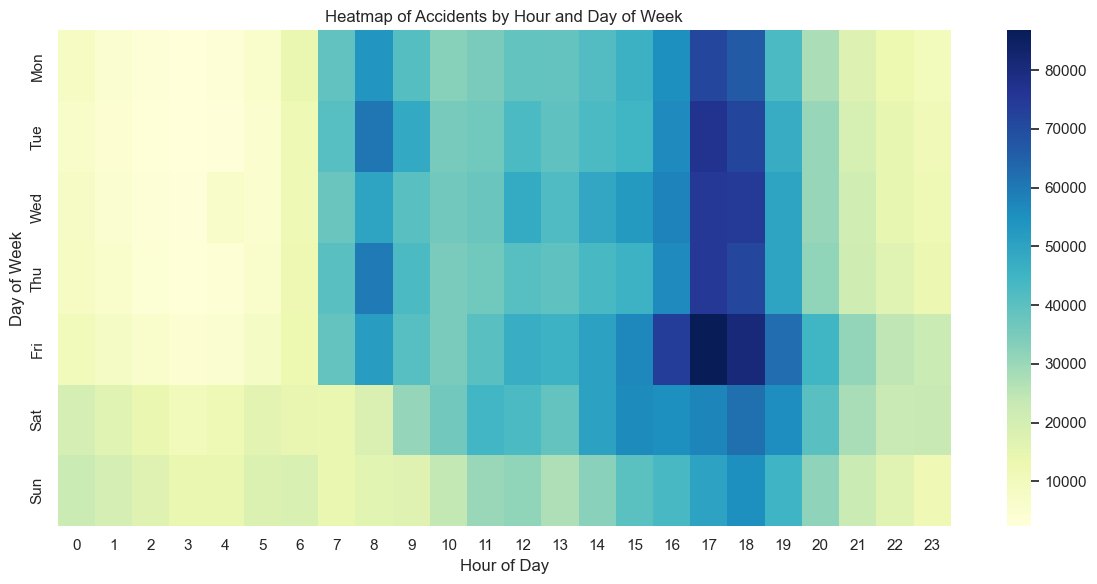

In [7]:
df["hour"] = pd.to_numeric(df["hour"], errors="coerce")
df["dayofweek"] = pd.to_numeric(df["dayofweek"], errors="coerce")

# Pivot table: rows = dayofweek, columns = hour
heatmap_data = df.pivot_table(index="dayofweek", columns="hour", values="num_acc", aggfunc="count")

# Map dayofweek to labels (0=Monday)
heatmap_data.index = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

# Plot
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=False, fmt="d")
plt.title("Heatmap of Accidents by Hour and Day of Week")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.tight_layout()
plt.show()